In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d robikscube/hourly-energy-consumption

# Unzip the downloaded dataset
!unzip -q hourly-energy-consumption.zip -d hourly-energy-consumption

  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 123MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [6]:
df = pd.read_csv('./hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


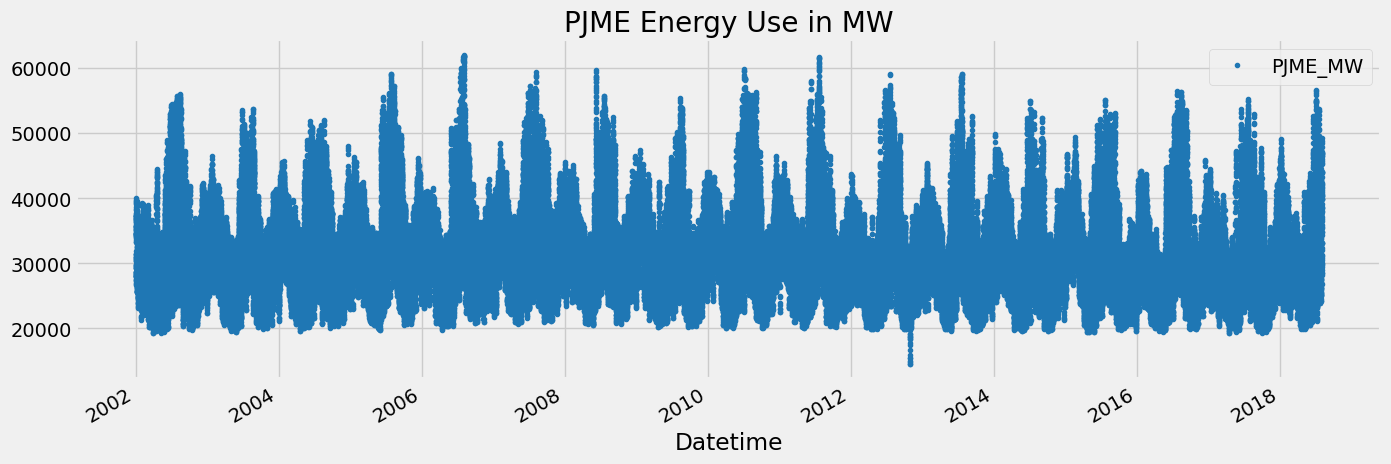

In [8]:
df.plot(style='.',
        figsize=(15,5),
        color =color_pal[0],
        title='PJME Energy Use in MW' )
plt.show()

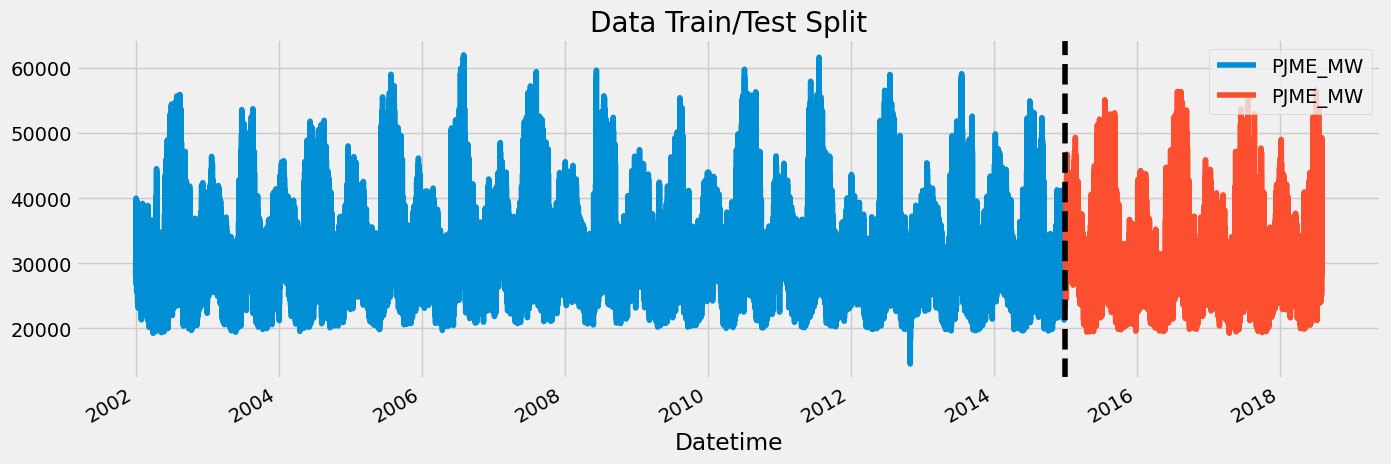

In [9]:
train = df.loc[df.index <= '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig , ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label ='Training Set', title = 'Data Train/Test Split')
test.plot (ax=ax, label ='Test Set')
ax.axvline('01-01-2015', color='black', ls='dashed')
plt.show()

<Axes: title={'center': 'One Week'}, xlabel='Datetime'>

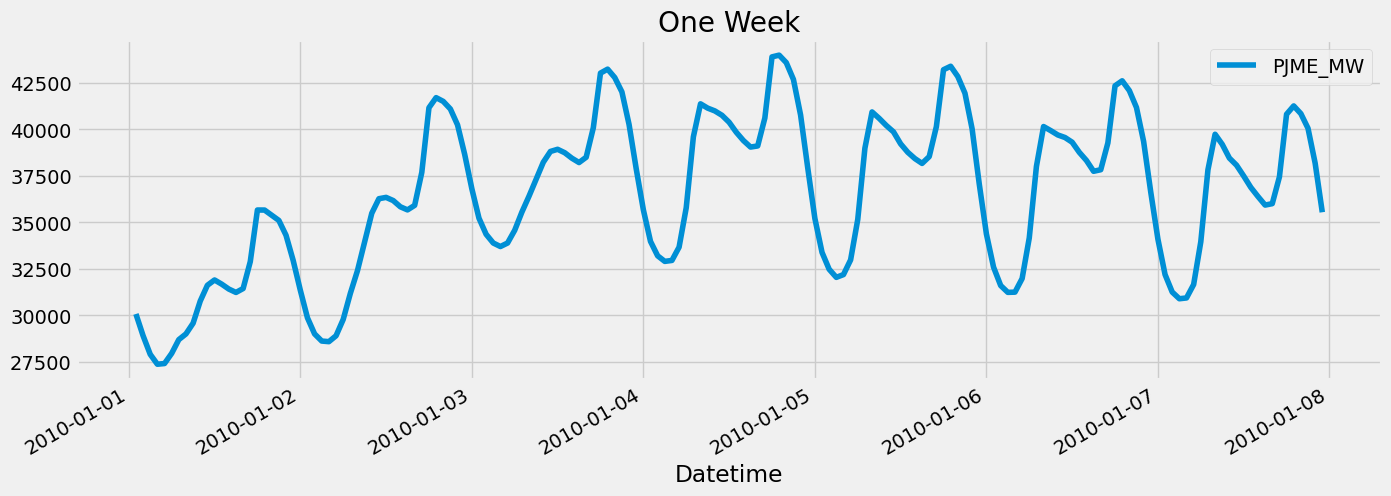

In [10]:
df.loc[(df.index >'01-01-2010') & (df.index <'01-08-2010')].plot(figsize=(15,5),title="One Week")

In [11]:

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


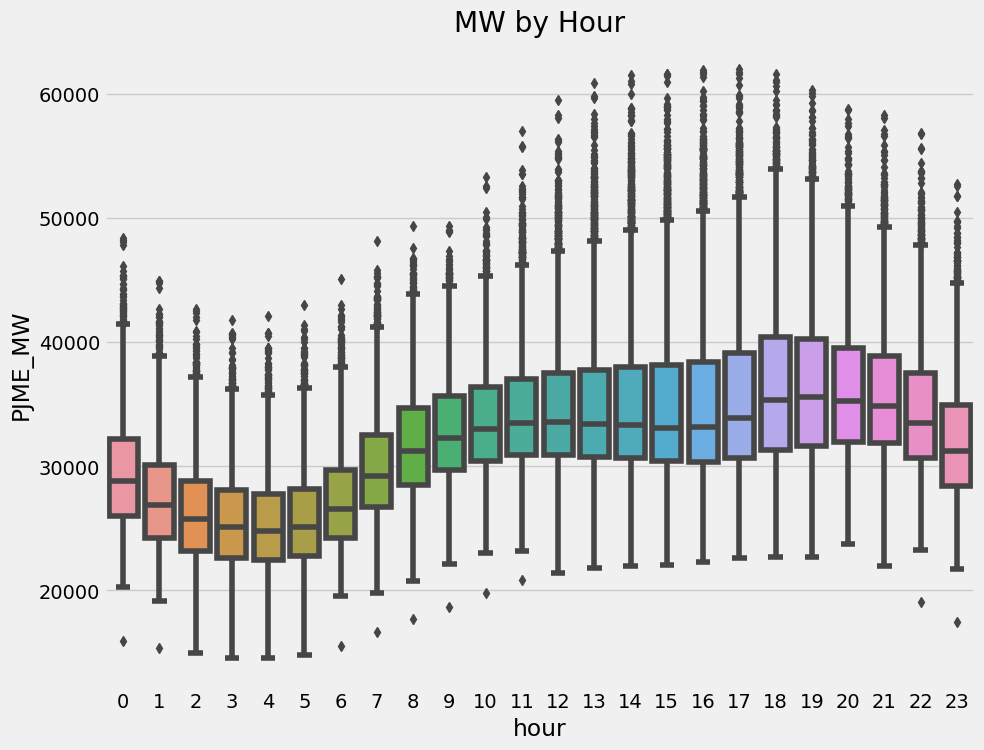

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

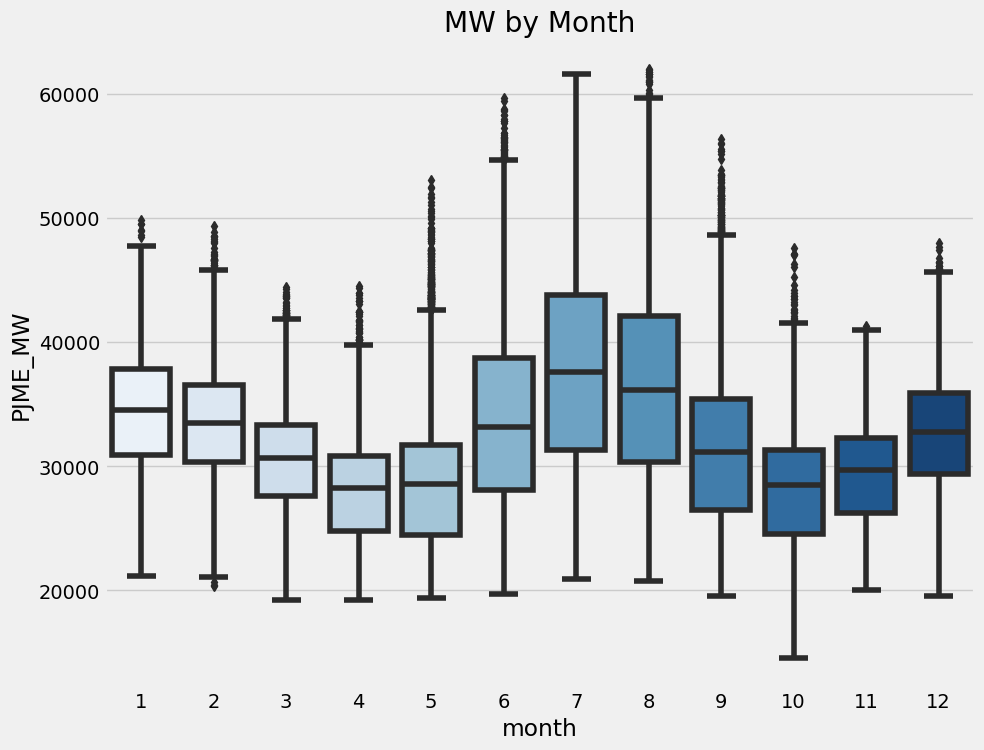

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

In [21]:
train = df.copy()
test = df.loc[df.index >= '01-01-2015']

In [24]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32404.29555	validation_1-rmse:31657.76184


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:24:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12536.59517	validation_1-rmse:11865.42533
[200]	validation_0-rmse:5873.32735	validation_1-rmse:5499.08631
[300]	validation_0-rmse:4008.03909	validation_1-rmse:4032.95109
[400]	validation_0-rmse:3546.29729	validation_1-rmse:3762.46703
[500]	validation_0-rmse:3394.93873	validation_1-rmse:3659.89001
[600]	validation_0-rmse:3321.69578	validation_1-rmse:3606.12685
[700]	validation_0-rmse:3270.81366	validation_1-rmse:3563.94717
[800]	validation_0-rmse:3235.04559	validation_1-rmse:3528.67433
[900]	validation_0-rmse:3206.87919	validation_1-rmse:3511.49487
[999]	validation_0-rmse:3184.24321	validation_1-rmse:3488.99073


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

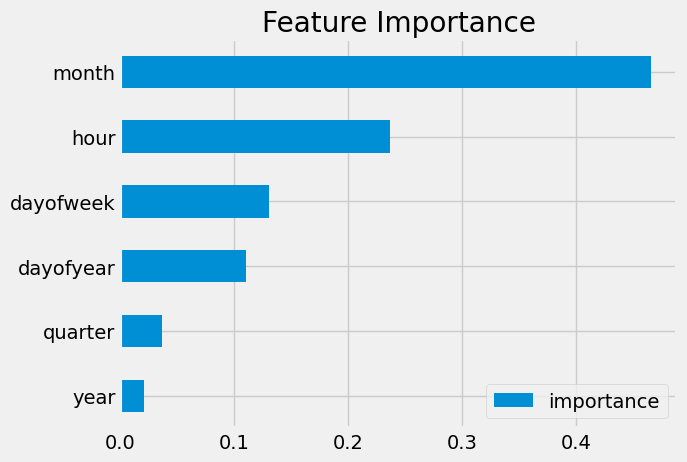

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<ipython-input-27-a37f417f53a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


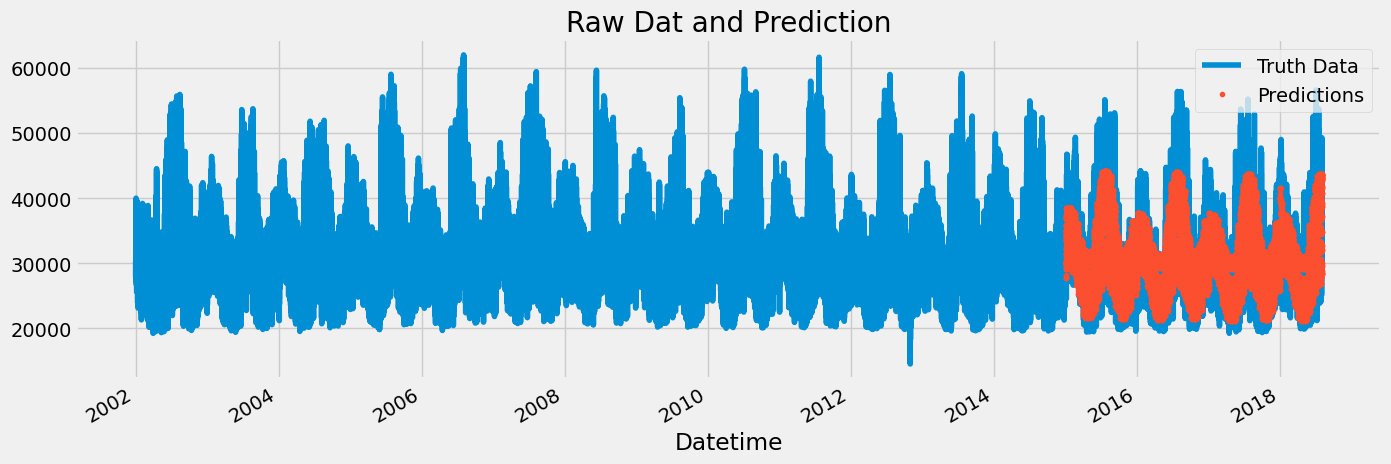

In [27]:
#Forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

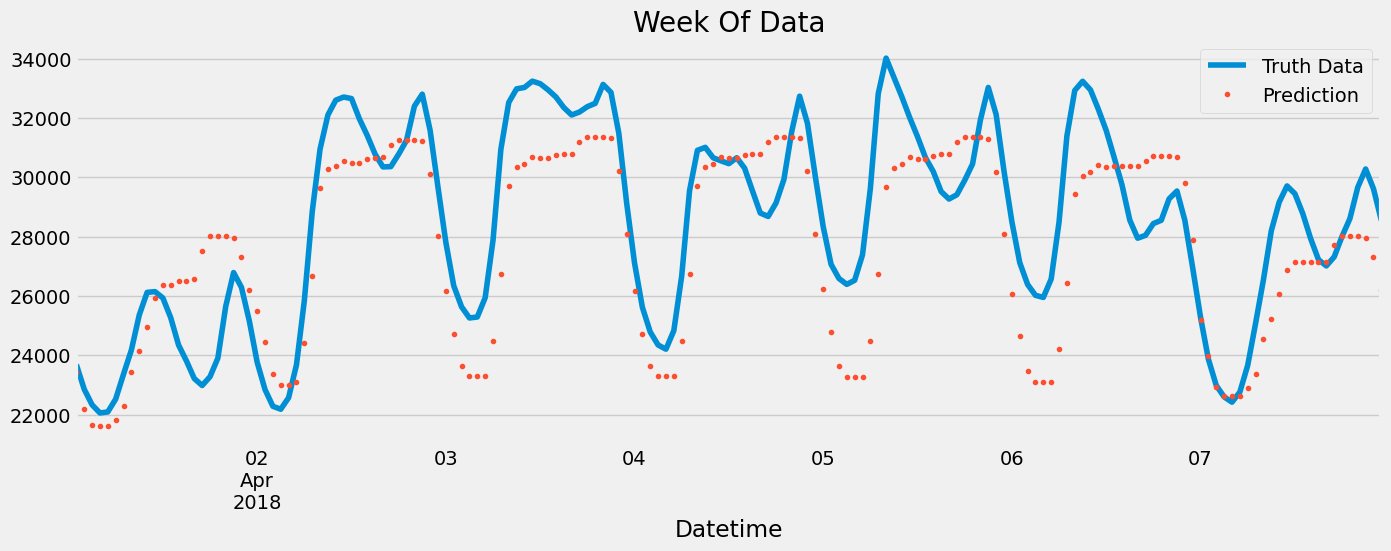

In [28]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [30]:
#RMSE
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3488.99


In [31]:
#Best and worst predictions
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    11466.446289
2016-08-13    11052.920980
2016-08-14    10922.022054
2016-09-09    10490.614258
2016-09-10    10203.715902
2015-02-21    10021.100586
2017-05-19     9882.298747
2015-02-16     9496.255290
2018-01-06     9329.803792
2018-07-02     9291.031169
Name: error, dtype: float64